In [1]:
%load_ext autoreload
%autoreload 2

In [258]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import src.utils
import seaborn as sns
import matplotlib.pyplot as plt

from src.evaluation import (
    evaluate,
    encode_sequences
    )
import src.config

import src.config
import src.data
import src.model_new
import src.utils
from src.model_new import (
    T5EncoderModelForTokenClassification,
)

import gc
import copy
import random

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

import peft
from peft import (
    LoraConfig,
)

'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/.venv/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [259]:
ROOT = src.utils.get_project_root_path()
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

USE_CRF = True
EXPERT = 'SP'

SEED = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
print("Path:\t\t", ROOT)
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 True
Path:		 /Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction
Using device:	 mps


In [179]:
targets = [""
    'SSSOTLTMLLLOOTSOOOLMTLMOLTLLMMLLLSLLSSSSOOOTTMSIOMITTITIOIITOTOTTLSTOTM',
    'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL',
    'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL'
    ]
predictions = [
    'SSSOTLTMLLLOOTSOOOLMTLMOLTLLMMLLLSLLSSSSOOOTTMSIOMITTITIOIITOTOTTLSTOTM',
    'MIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIIIIIMIIIMMIIIMIIIL',
    'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIMMMMMMMMIIIIIIIIOSTIMIIIMMIIIMIIIL'
    ]

predictions = encode_sequences(predictions, encoding=src.config.label_encoding)
targets = encode_sequences(targets, encoding=src.config.label_encoding)

In [180]:
evaluation = evaluate(
    predictions=predictions,
    targets=targets,
    encoding=src.config.label_encoding,
    decoding=src.config.label_decoding
)

/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:31: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:33: RuntimeWarning: invalid value encountered in divide
  PPV = TP/(TP+FP)
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:36: RuntimeWarning: invalid value encountered in divide
  FNR = FN/(TP+FN)
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:37: RuntimeWarning: invalid value encountered in divide
  FDR = FP/(TP+FP)
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:44: RuntimeWarning: invalid value encountered in divide
  MCC_2 = (TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
/Users/finnlueth/Developer/gits/prottrans-t5-signalpeptide-prediction/src/evaluation.py:33: RuntimeWarning: invalid value encountered in di

In [221]:
df_evaluation = pd.DataFrame(evaluation)

In [255]:
df_evaluation_MCC = pd.DataFrame(df_evaluation['MCC_2'].to_list(), columns=src.config.label_encoding)
df_evaluation_MCC_mean = pd.DataFrame(np.nanmean(df_evaluation_MCC, axis=0).reshape(-1, 6), columns=src.config.label_encoding)
df_evaluation_MCC_dev = pd.DataFrame(np.std(df_evaluation_MCC, axis=0)).T
df_evaluation_MCC_error = pd.DataFrame(np.std(df_evaluation_MCC, axis=0, ddof=1)).T
display(df_evaluation_MCC, df_evaluation_MCC_mean, df_evaluation_MCC_error)
# display(df_evaluation_MCC)

,I,L,M,O,S,T
0,1.000000,1.0,1.000000,1.0,1.0,1.0
1,0.955281,1.0,0.952592,NaN,NaN,NaN
2,0.877767,1.0,1.000000,NaN,NaN,NaN


,I,L,M,O,S,T
0,0.944349,1.0,0.984197,1.0,1.0,1.0


,I,L,M,O,S,T
0,0.061846,0.0,0.027371,NaN,NaN,NaN


<Axes: title={'center': 'MCC Error'}, xlabel='Labels', ylabel='Error'>

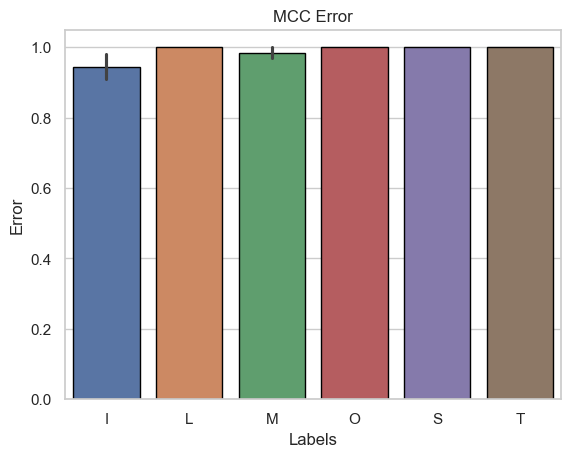

In [253]:
src.evaluation.plot_mcc(df_evaluation_MCC)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Actual', ylabel='Predicted'>

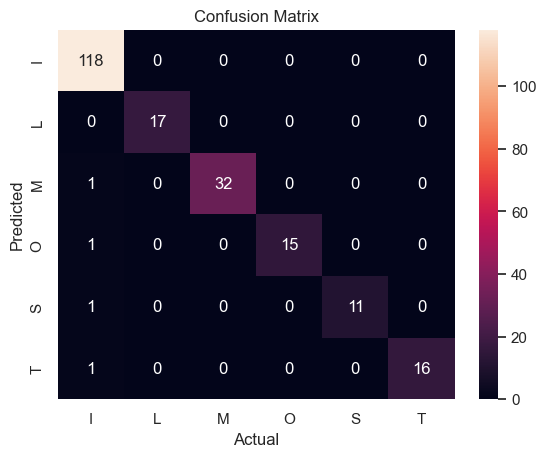

In [250]:
src.evaluation.plot_confusion_matrix(df_evaluation['CM'].sum(), src.config.label_decoding)

In [269]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

In [270]:
df_data.shape

(20758, 6)

In [273]:
df_data[df_data['Sequence'].str.startswith('M A A V I L E R L G A L W V Q N L R G K L A L G I L P Q')]

,Uniprot_AC,Kingdom,Type,Partition_No,Sequence,Label
4622,Q3SZX5,EUKARYA,NO_SP,4,M A A V I L E R L G A L W V Q N L R G K L A L ...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [262]:
'M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M'.replace(' ', '')

'MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM'

In [ ]:
df_data